In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from random import shuffle

from scipy.spatial import distance

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)

In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    

    # bits shuffling for equal bits
    eq_bits = [[0 for i in range(num_agents//2)] + [1 for i in range(num_agents//2)] for i in range(number_of_bits)]
    for i in eq_bits:
        shuffle(i)
        
    list_agents = []
    tau_distr = get_tau_distr()
    for i in range(num_agents):

        in_state = [bit.pop() for bit in eq_bits]

        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coherence, bit_mat, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d)

### The heatmap in the section below shows the coherence matrix with attractors and their depth and radius

In [7]:
random.seed(0)
number_attractors = 5 # assign number of attractors for the coherence matrix with attractor space

attractors = {}
radius = [1, 10, 30, 5, 7]

while len(attractors) < number_attractors:
    attractor_state = random.randint(0,2**number_of_bits)
    attractor_depth = random.random() # depth for each attractors is picked randomly
    attractor_radius = random.choice(radius)
    
    attractors[attractor_state] = {'depth': attractor_depth, 'radius': attractor_radius}
    
attractors

{788: {'depth': 0.7579544029403025, 'radius': 5},
 82: {'depth': 0.25891675029296335, 'radius': 7},
 995: {'depth': 0.4049341374504143, 'radius': 30},
 976: {'depth': 0.3580493746949883, 'radius': 10},
 285: {'depth': 0.28183784439970383, 'radius': 1}}

In [8]:
def hamming(a,b):
    return(bin(a^b).count("1"))

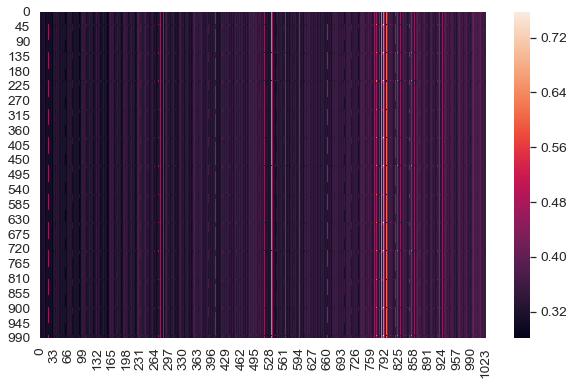

In [9]:
attrctr_space_vec = np.zeros(2**number_of_bits)

for k, v in attractors.items():
    attrctr_space_vec[k] = v['depth']
    r = v['radius']
    n = 2**number_of_bits
    for j in range(2**number_of_bits):
            diff = hamming(j, k)
#             diff = abs(j-k) ### Uncomment if needed to look into euclidean space
            if diff <= r:
                attrctr_state_distance = (1-diff/v['radius'])*v['depth']
                attrctr_space_vec[j] = max(attrctr_space_vec[j], attrctr_state_distance)
            
attrctr_space_mat = np.tile(attrctr_space_vec, (2**number_of_bits, 1))
        
sns.heatmap(attrctr_space_mat);


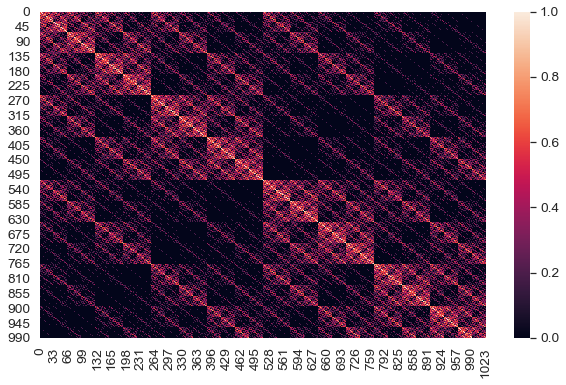

In [10]:
# create transition matrix
inertia_matrix = np.zeros((2**number_of_bits, 2**number_of_bits))

max_bits = 5 # maximum bits to for the transitions
    
for row_st, row in enumerate(inertia_matrix):
    for col_st, col in enumerate(row):
        bits_difference = hamming(row_st, col_st)
#         bits_difference = np.abs(row_st- col_st)
        inertia_matrix[row_st, col_st] = max(0, 1- bits_difference *(1/max_bits))

sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)
sns.heatmap(inertia_matrix);

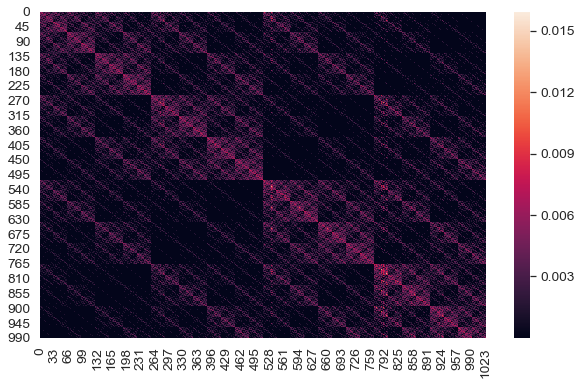

In [11]:
coherence_matrix = attrctr_space_mat*inertia_matrix

# add noise to coherence matrix:
for i, row in enumerate(coherence_matrix):
    for j, col in enumerate(row):
        if col == 0:
            coherence_matrix[i][j] += 0.00000001

    # normalizing        
    summing = sum(row)
    for j, col in enumerate(row):
        coherence_matrix[i][j] = coherence_matrix[i][j]/summing  
sns.heatmap(coherence_matrix);

Verifying normalization:

In [12]:
print(sum(coherence_matrix.sum(axis=1) < 1.01))
print(sum(coherence_matrix.sum(axis=1) > 0.99999))

1024
1024


In [13]:
coherence_matrix.max()*100

1.5932569848954397

The max is 1.59 % means when at any state, it can go to any other state or not much effect of attractors.

# Running simulations

In [14]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)
constants = const.Constants()

bit_mat = constants.get_bit_matrix()

Initializing matrix using bitblock method again


### Finding if all states are covered in initialization

In [15]:
initial_state_count = pd.DataFrame(pd.DataFrame([utilities.bool2int(i.knowledge_state) for i in agents_list])[0].value_counts()).reset_index()
initial_state_count.columns = ['states', 'count']
initial_state_count['states'].nunique()

790

In [16]:
2**number_of_bits

1024

In [17]:
num_agents

1500

In [18]:
record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df = run_simulation(alpha, coherence_matrix, bit_mat, agents_list, end_simulation_time)
        record_df = record_df.append(tmp_record_df)

### Viewing the state transitions in the above coherence matrix

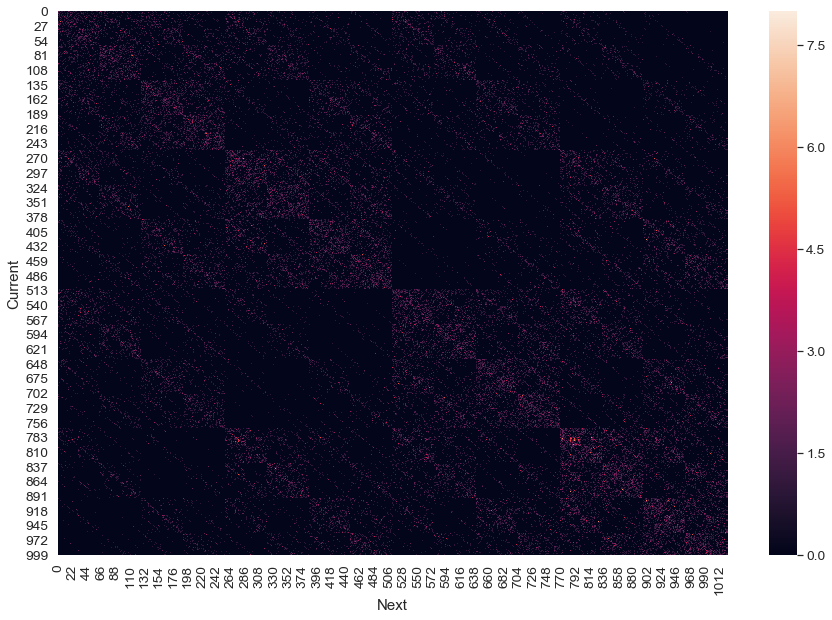

In [19]:
state_transitions = pd.crosstab(record_df['Current'], record_df['Next'])
sns.set(style='darkgrid', rc={'figure.figsize':(15,10)}, font_scale=1.25)
sns.heatmap(state_transitions);

In [20]:
# record_df[['Current', 'Next']].to_csv('state_transitions.csv', index=False)

# Now using embedding

The embedding code is used from (GitHub GraphEmbedding)[https://github.com/shenweichen/GraphEmbedding]. Only part that are of SDNE were taken for embedding.

In [21]:
# Following code is from https://github.com/shenweichen/GraphEmbedding
"""
Author:
    Weichen Shen,wcshen1994@163.com
Reference:
    [1] Wang D, Cui P, Zhu W. Structural deep network embedding[C]//Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2016: 1225-1234.(https://www.kdd.org/kdd2016/papers/files/rfp0191-wangAemb.pdf)
"""
import time

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import History
from tensorflow.python.keras.layers import Dense, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l1_l2

import networkx as nx
import pandas as pd

def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx

def l_2nd(beta):
    def loss_2nd(y_true, y_pred):
        b_ = np.ones_like(y_true)
        b_[y_true != 0] = beta
        x = K.square((y_true - y_pred) * b_)
        t = K.sum(x, axis=-1, )
        return K.mean(t)

    return loss_2nd


def l_1st(alpha):
    def loss_1st(y_true, y_pred):
        L = y_true
        Y = y_pred
        batch_size = tf.to_float(K.shape(L)[0])
        return alpha * 2 * tf.linalg.trace(tf.matmul(tf.matmul(Y, L, transpose_a=True), Y)) / batch_size

    return loss_1st


def create_model(node_size, hidden_size=[256, 128], l1=1e-5, l2=1e-4):
    A = Input(shape=(node_size,))
    L = Input(shape=(None,))
    fc = A
    for i in range(len(hidden_size)):
        if i == len(hidden_size) - 1:
            fc = Dense(hidden_size[i], activation='relu',
                       kernel_regularizer=l1_l2(l1, l2), name='1st')(fc)
        else:
            fc = Dense(hidden_size[i], activation='relu',
                       kernel_regularizer=l1_l2(l1, l2))(fc)
    Y = fc
    for i in reversed(range(len(hidden_size) - 1)):
        fc = Dense(hidden_size[i], activation='relu',
                   kernel_regularizer=l1_l2(l1, l2))(fc)

    A_ = Dense(node_size, 'relu', name='2nd')(fc)
    model = Model(inputs=[A, L], outputs=[A_, Y])
    emb = Model(inputs=A, outputs=Y)
    return model, emb


class SDNE(object):
    def __init__(self, graph, hidden_size=[32, 16], alpha=1e-6, beta=5., nu1=1e-5, nu2=1e-4, ):

        self.graph = graph
        # self.g.remove_edges_from(self.g.selfloop_edges())
        self.idx2node, self.node2idx = preprocess_nxgraph(self.graph)

        self.node_size = self.graph.number_of_nodes()
        self.hidden_size = hidden_size
        self.alpha = alpha
        self.beta = beta
        self.nu1 = nu1
        self.nu2 = nu2

        self.A, self.L = self._create_A_L(
            self.graph, self.node2idx)  # Adj Matrix,L Matrix
        self.reset_model()
        self.inputs = [self.A, self.L]
        self._embeddings = {}

    def reset_model(self, opt='adam'):

        self.model, self.emb_model = create_model(self.node_size, hidden_size=self.hidden_size, l1=self.nu1,
                                                  l2=self.nu2)
        self.model.compile(opt, [l_2nd(self.beta), l_1st(self.alpha)])
        self.get_embeddings()

    def train(self, batch_size=1024, epochs=1, initial_epoch=0, verbose=1):
        if batch_size >= self.node_size:
            if batch_size > self.node_size:
                print('batch_size({0}) > node_size({1}),set batch_size = {1}'.format(
                    batch_size, self.node_size))
                batch_size = self.node_size
            return self.model.fit([self.A.todense(), self.L.todense()], [self.A.todense(), self.L.todense()],
                                  batch_size=batch_size, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose,
                                  shuffle=False, )
        else:
            steps_per_epoch = (self.node_size - 1) // batch_size + 1
            hist = History()
            hist.on_train_begin()
            logs = {}
            for epoch in range(initial_epoch, epochs):
                start_time = time.time()
                losses = np.zeros(3)
                for i in range(steps_per_epoch):
                    index = np.arange(
                        i * batch_size, min((i + 1) * batch_size, self.node_size))
                    A_train = self.A[index, :].todense()
                    L_mat_train = self.L[index][:, index].todense()
                    inp = [A_train, L_mat_train]
                    batch_losses = self.model.train_on_batch(inp, inp)
                    losses += batch_losses
                losses = losses / steps_per_epoch

                logs['loss'] = losses[0]
                logs['2nd_loss'] = losses[1]
                logs['1st_loss'] = losses[2]
                epoch_time = int(time.time() - start_time)
                hist.on_epoch_end(epoch, logs)
                if verbose > 0:
                    print('Epoch {0}/{1}'.format(epoch + 1, epochs))
                    print('{0}s - loss: {1: .4f} - 2nd_loss: {2: .4f} - 1st_loss: {3: .4f}'.format(
                        epoch_time, losses[0], losses[1], losses[2]))
            return hist

    def evaluate(self, ):
        return self.model.evaluate(x=self.inputs, y=self.inputs, batch_size=self.node_size)

    def get_embeddings(self):
        self._embeddings = {}
        embeddings = self.emb_model.predict(self.A.todense(), batch_size=self.node_size)
        look_back = self.idx2node
        for i, embedding in enumerate(embeddings):
            self._embeddings[look_back[i]] = embedding

        return self._embeddings

    def _create_A_L(self, graph, node2idx):
        node_size = graph.number_of_nodes()
        A_data = []
        A_row_index = []
        A_col_index = []

        for edge in graph.edges():
            v1, v2 = edge
            edge_weight = graph[v1][v2].get('weight', 1)

            A_data.append(edge_weight)
            A_row_index.append(node2idx[v1])
            A_col_index.append(node2idx[v2])

        A = sp.csr_matrix((A_data, (A_row_index, A_col_index)), shape=(node_size, node_size))
        A_ = sp.csr_matrix((A_data + A_data, (A_row_index + A_col_index, A_col_index + A_row_index)),
                           shape=(node_size, node_size))

        D = sp.diags(A_.sum(axis=1).flatten().tolist()[0])
        L = D - A_
        return A, L

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

### Running SDNE embedding

In [22]:
G = nx.from_pandas_edgelist(record_df, source='Current', target='Next')
model = SDNE(G,hidden_size=[256,128]) #init model
model.train(batch_size=3000,epochs=1000,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
batch_size(3000) > node_size(1024),set batch_size = 1024
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 0s - loss: 2312.4661 - 2nd_loss: 2312.2595 - 1st_loss: 0.0012
Epoch 2/1000
 - 0s - loss: 2254.7148 - 2nd_loss: 2254.5081 - 1st_loss: 0.0016
Epoch 3/1000
 - 0s - loss: 2204.4399 - 2nd_loss: 2204.2329 - 1st_loss: 0.0018
Epoch 4/1000
 - 0s - loss: 2158.4717 - 2nd_loss: 2158.2646 - 1st_loss: 0.0018
Epoch 5/1000
 - 0s - loss: 2119.2632 - 2nd_loss: 2119.0557 - 1st_loss: 0.0018
Epoch 6/1000
 - 0s - loss: 2086.0676 - 2nd_loss: 2085.8601 - 1st_loss: 0.0018
Epoch 7/1000
 - 0s - loss: 2057.0786 - 2nd_loss: 2056.8713 - 1st_loss: 0.0018
Epoch 8/1000
 - 0s - loss: 2031.4506 - 2nd_loss: 2031.2434 - 1st_loss: 0.0018
Epoch 9/1000
 - 0s - loss: 2007.7435 - 2nd_loss: 2007.5361 - 1st_loss: 0.0018
Epoch 10/1000
 - 0s - loss: 1984.5040 - 2nd_loss: 1984.2966 - 1st_loss: 0

In [25]:
embedded = np.zeros((1024, 128))
for k, v in embeddings.items():
    embedded[k] = v

In [26]:
from sklearn.preprocessing import StandardScaler


In [27]:
x = StandardScaler().fit_transform(embedded)

In [28]:
Y = [i for i in range(1024)]

In [29]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.cubehelix_palette(1024)

In [30]:
tsne = TSNE()
X_embedded = tsne.fit_transform(embedded)

### Plotting without scaling

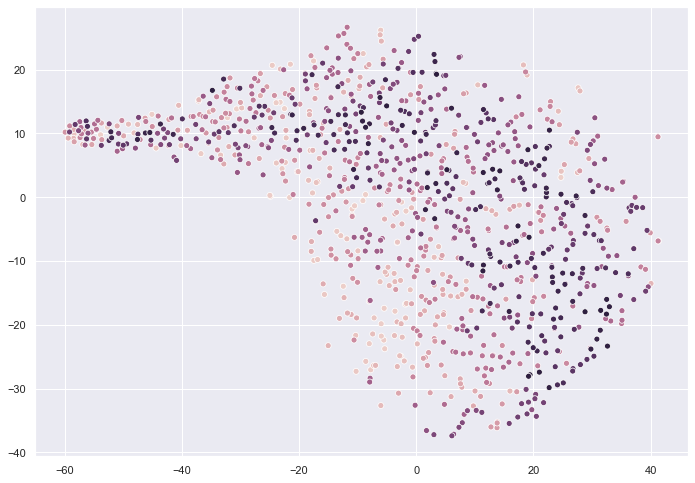

In [31]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y, legend=None, palette=palette)

### Plotting with scaling

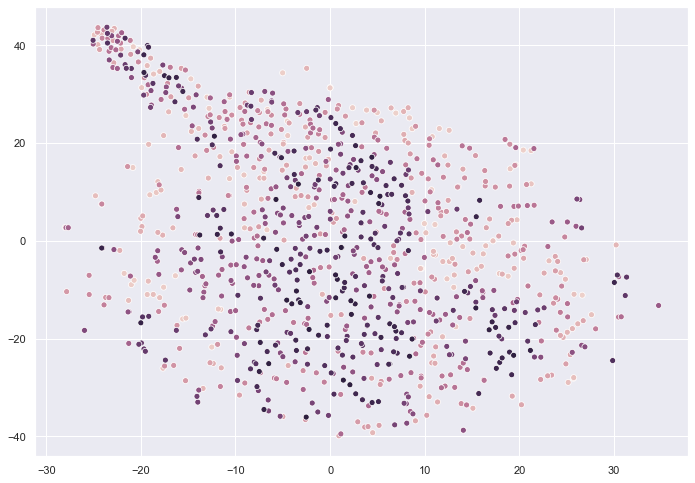

In [32]:
tsne = TSNE()
X_embedded = tsne.fit_transform(x)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y, legend=None, palette=palette)

In [33]:
record_df['Current'].value_counts()

788    377
784    283
789    281
772    279
852    272
796    271
532    270
916    268
820    268
276    261
790    260
854    221
821    217
797    217
404    215
816    212
792    212
798    212
900    211
884    211
912    210
860    209
836    209
853    208
791    207
768    205
948    205
278    205
773    204
534    204
      ... 
220    113
446    113
157    113
560    113
31     113
180    112
10     112
94     112
140    112
648    112
7      112
218    112
702    112
24     111
59     110
478    110
61     110
78     109
52     108
29     108
168    108
89     107
142    107
285    106
76     106
217    105
92     104
158    102
125    102
26      99
Name: Current, Length: 1024, dtype: int64

In [34]:
record_df[record_df['Current'] == record_df['Next']].shape # total transitions that did not change

(1167, 8)

In [35]:
record_df.shape # total transitions

(150000, 8)